In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/textstat/textstat-0.7.1-py3-none-any.whl
/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv
/kaggle/input/pyphen/Pyphen-0.10.0-py3-none-any.whl


In [2]:
!pip install ../input/pyphen/Pyphen-0.10.0-py3-none-any.whl

Processing /kaggle/input/pyphen/Pyphen-0.10.0-py3-none-any.whl


In [3]:
!pip install ../input/textstat/textstat-0.7.1-py3-none-any.whl

Processing /kaggle/input/textstat/textstat-0.7.1-py3-none-any.whl


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import textstat
from textstat.textstat import textstatistics
import nltk
nltk.download(['punkt', 'wordnet'])
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

[nltk_data] <urlopen error [Errno -3] Temporary failure in name
[nltk_data]     resolution>


In [5]:
train_df = pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv')
test_df = pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv')

In [6]:
train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [7]:
train_df.shape

(2834, 6)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   url_legal       830 non-null    object 
 2   license         830 non-null    object 
 3   excerpt         2834 non-null   object 
 4   target          2834 non-null   float64
 5   standard_error  2834 non-null   float64
dtypes: float64(2), object(4)
memory usage: 133.0+ KB


In [9]:
train_df.isnull().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

In [10]:
test_df.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [11]:
test_df.shape

(7, 4)

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7 non-null      object
 1   url_legal  3 non-null      object
 2   license    3 non-null      object
 3   excerpt    7 non-null      object
dtypes: object(4)
memory usage: 352.0+ bytes


In [13]:
test_df.isnull().sum()

id           0
url_legal    4
license      4
excerpt      0
dtype: int64

In [14]:
train_df = train_df.drop_duplicates()
train_df.shape

(2834, 6)

In [15]:
test_df = test_df.drop_duplicates()
test_df.shape

(7, 4)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='standard_error', ylabel='Density'>

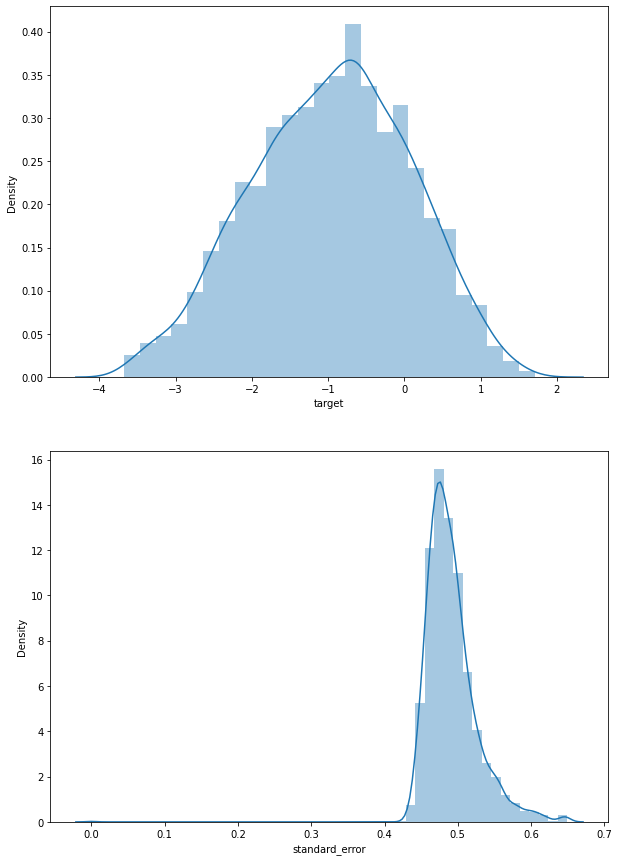

In [16]:
fig = plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
sns.distplot(train_df['target'])
plt.subplot(2,1,2)
sns.distplot(train_df['standard_error'])

The graph representing the target values seems normally distributed representing that rating done for the article where most of them are medium complex and other are either too easy or too hard to be classified correctly.

Graph representing standard_error in the dataset looks to be at 0.5 error value which means that most of the passage which the user is not to understand are misjudge to be of medium complexibility by them.

In [17]:
#dropping columns url_legal and license
train_df = train_df.drop(columns=['url_legal','license'],axis=1)

Adding few new columns into the train_df displaying summary count of words and sentence in the passage mentioned in excerpt.

In [18]:
summary_df = train_df

In [19]:
summary_df.head()

,id,excerpt,target,standard_error
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [20]:
no_sentence = []
total_word = 0
average_word = 0
no_words = []
average_word_sen = []
for passage in summary_df['excerpt']:
    count_sen = len(re.findall(r'\.', passage))
    no_sentence.append(count_sen)
    for sen in passage:
        count_word = len(re.findall(r'\w+', sen))
        total_word += count_word
    average_word = total_word/count_sen
    no_words.append(total_word)
    average_word_sen.append(average_word)
summary_df['no_sen'] = no_sentence
summary_df['no_word'] = no_words
summary_df['average_word_sen'] = average_word_sen

In [21]:
count_letter = 0
total_letter = []
all_word = []
count_unique_word = []
for passage in summary_df['excerpt']:
    for word in re.findall(r'\w+', passage):
        all_word.append(word)
        count_letter += len(word)
    all_word = list(set(all_word))
    count_unique_word.append(len(all_word))
    total_letter.append(count_letter)
summary_df['letter_count'] = count_letter
summary_df['count_unique_word'] = count_unique_word

In [22]:
count = 0
unique_words = []
count_non_stop = []
stop_words = list(set(stopwords.words('english')))
for passage in summary_df['excerpt']:
    words = word_tokenize(passage)
    for w in words:
        if w not in stop_words and w not in unique_words:
            count += 1
            unique_words.append(w)
    count_non_stop.append(count)
summary_df['count_non_stop'] = count_non_stop

In [23]:
passage_length = []
max_pass_len = []
min_pass_len = []
sent_passage = []
for passage in summary_df['excerpt']:
    passage_length.append(len(passage))
    sent_length = sent_tokenize(passage)
    sent_passage.append(sent_length)
    max_pass_len.append(len(max(sent_length)))
    min_pass_len.append(len(min(sent_length)))
summary_df['passage_length'] = passage_length
summary_df['max_pass_len'] = max_pass_len
summary_df['min_pass_len'] = min_pass_len

In [24]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2834 entries, 0 to 2833
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2834 non-null   object 
 1   excerpt            2834 non-null   object 
 2   target             2834 non-null   float64
 3   standard_error     2834 non-null   float64
 4   no_sen             2834 non-null   int64  
 5   no_word            2834 non-null   int64  
 6   average_word_sen   2834 non-null   float64
 7   letter_count       2834 non-null   int64  
 8   count_unique_word  2834 non-null   int64  
 9   count_non_stop     2834 non-null   int64  
 10  passage_length     2834 non-null   int64  
 11  max_pass_len       2834 non-null   int64  
 12  min_pass_len       2834 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 310.0+ KB


# Dale Chall Readability Score

In [25]:
dale_chall_list = []
for text in summary_df['excerpt']:
    dale_chall = textstat.dale_chall_readability_score(text)
    dale_chall_list.append(dale_chall)
print(len(dale_chall_list))

2834


In [26]:
coleman_liau_list = []
for text in summary_df['excerpt']:
    coleman_liau = textstat.coleman_liau_index(text)
    coleman_liau_list.append(coleman_liau)
print(len(coleman_liau_list))

2834


In [27]:
smog_index_list = []
for text in summary_df['excerpt']:
    smog_index = textstat.smog_index(text)
    smog_index_list.append(smog_index)
print(len(smog_index_list))

2834


In [28]:
automated_readability_index_list = []
for text in summary_df['excerpt']:
    automated_readability_index = textstat.automated_readability_index(text)
    automated_readability_index_list.append(automated_readability_index)
print(len(automated_readability_index_list))

2834


In [29]:
linsear_write_formula_list = []
for text in summary_df['excerpt']:
    linsear_write_formula = textstat.linsear_write_formula(text)
    linsear_write_formula_list.append(linsear_write_formula)
print(len(linsear_write_formula_list))

2834


In [30]:
gunning_fog_list = []
for text in summary_df['excerpt']:
    gunning_fog = textstat.gunning_fog(text)
    gunning_fog_list.append(gunning_fog)
print(len(gunning_fog_list))

2834


In [31]:
flesch_reading_ease_list = []
for text in summary_df['excerpt']:
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_reading_ease_list.append(flesch_reading_ease)
print(len(flesch_reading_ease_list))

2834


In [32]:
flesch_kincaid_grade_list = []
for text in summary_df['excerpt']:
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
    flesch_kincaid_grade_list.append(flesch_kincaid_grade)
print(len(flesch_kincaid_grade_list))

2834


In [33]:
difficult_words_list = []
for text in summary_df['excerpt']:
    difficult_words = textstat.difficult_words(text)
    difficult_words_list.append(difficult_words)
print(len(difficult_words_list))

2834


In [34]:
summary_df['dale_chall_list'] = dale_chall_list
summary_df['coleman_liau_list'] = coleman_liau_list
summary_df['smog_index_list'] = smog_index_list
summary_df['automated_readability_index_list'] = automated_readability_index_list
summary_df['linsear_write_formula_list'] = linsear_write_formula_list
summary_df ['gunning_fog_list'] = gunning_fog_list
summary_df['flesch_reading_ease_list'] = flesch_reading_ease_list
summary_df['flesch_kincaid_grade_list'] = flesch_kincaid_grade_list
summary_df['flesch_kincaid_grade_list'] = flesch_kincaid_grade_list

In [35]:
summary_df

,id,excerpt,target,standard_error,no_sen,no_word,average_word_sen,letter_count,count_unique_word,count_non_stop,...,max_pass_len,min_pass_len,dale_chall_list,coleman_liau_list,smog_index_list,automated_readability_index_list,linsear_write_formula_list,gunning_fog_list,flesch_reading_ease_list,flesch_kincaid_grade_list
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,11,787,71.545455,2184812,110,84,...,92,108,6.65,8.06,8.6,8.3,9.000000,8.31,80.31,6.1
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,10,1500,150.000000,2184812,206,167,...,17,92,5.92,6.78,8.3,7.2,7.285714,7.53,82.54,5.2
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,11,2196,199.636364,2184812,288,237,...,53,37,6.29,7.20,10.1,10.1,14.750000,10.49,75.74,7.9
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,5,2909,581.800000,2184812,371,313,...,60,205,6.61,8.54,6.7,16.4,12.500000,13.61,72.02,11.4
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,5,3454,690.800000,2184812,397,338,...,171,168,1.57,4.83,8.8,11.8,13.500000,11.76,75.47,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.646900,10,2181989,218198.900000,2184812,29971,32798,...,70,49,6.37,10.88,8.4,8.8,5.222222,6.69,77.03,5.3
2830,2c26db523,So what is a solid? Solids are usually hard be...,0.189476,0.535648,13,2182697,167899.769231,2184812,29973,32800,...,54,67,5.95,6.59,8.4,5.3,4.700000,6.39,84.98,4.3
2831,cd19e2350,The second state of matter we will discuss is ...,0.255209,0.483866,16,2183432,136464.500000,2184812,29975,32803,...,23,45,5.52,3.98,7.3,3.0,4.090909,5.95,85.49,4.1
2832,15e2e9e7a,Solids are shapes that you can actually touch....,-0.215279,0.514128,12,2184114,182009.500000,2184812,29985,32812,...,90,73,6.68,8.34,8.1,7.3,5.444444,6.87,84.17,4.6


<AxesSubplot:>

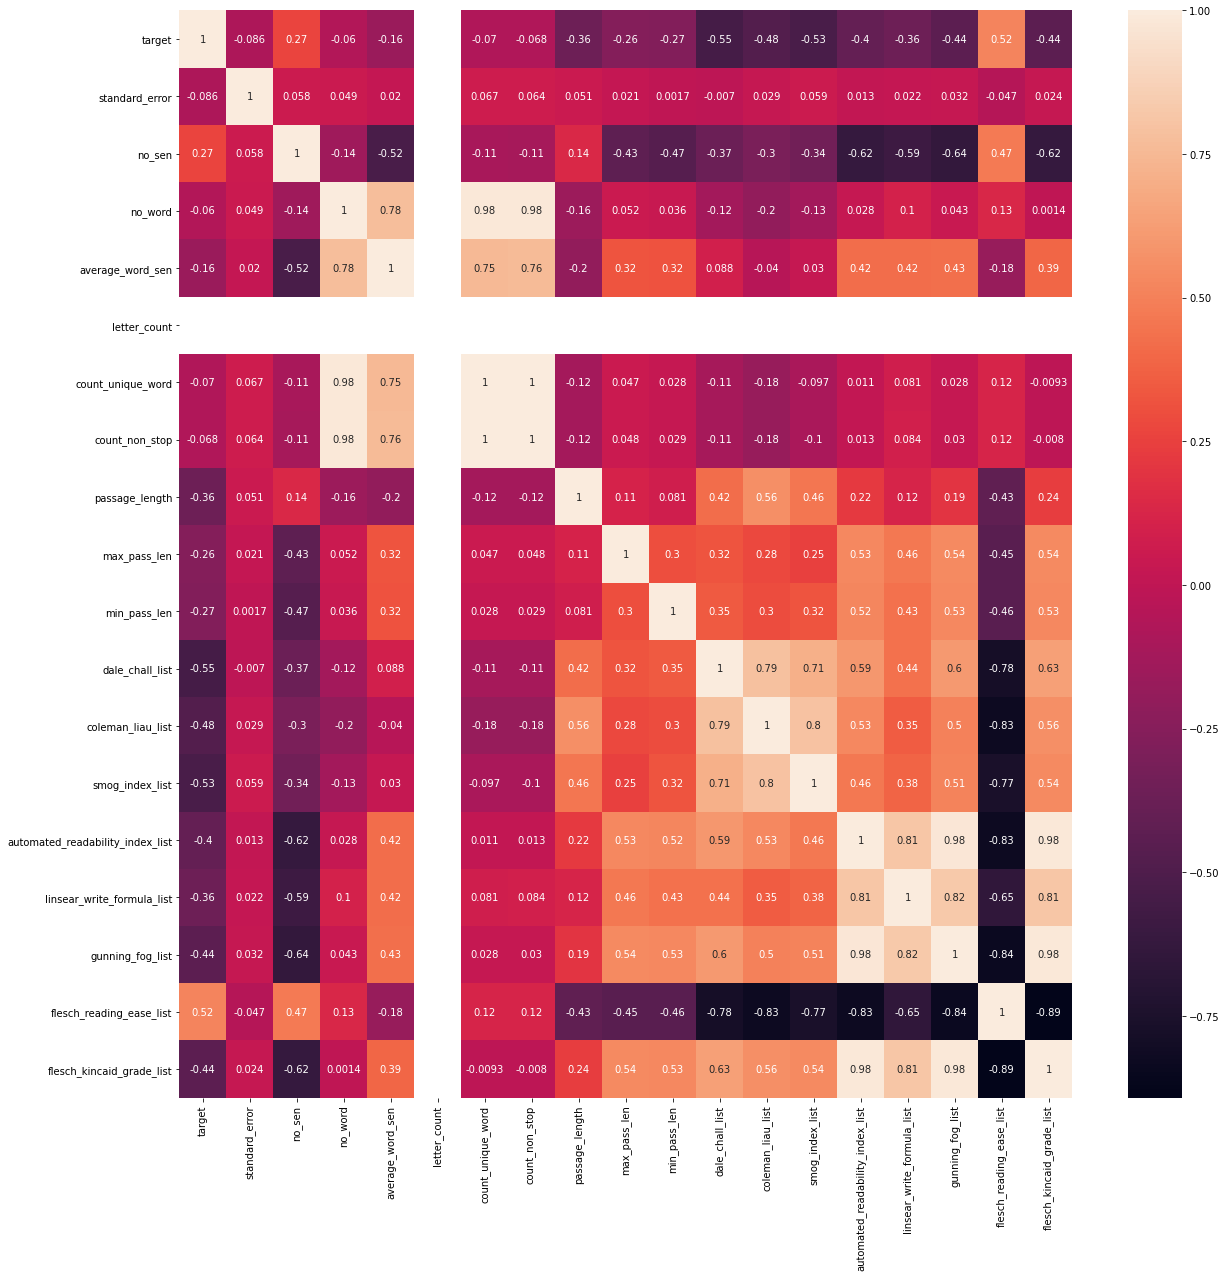

In [36]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(summary_df.corr(), annot = True)

In [37]:
summary_df = summary_df.drop(columns=['no_sen','no_word', 'dale_chall_list', 'smog_index_list', 'count_non_stop', 'letter_count', 'flesch_reading_ease_list', 'automated_readability_index_list', 'gunning_fog_list', 'flesch_kincaid_grade_list'])

<AxesSubplot:>

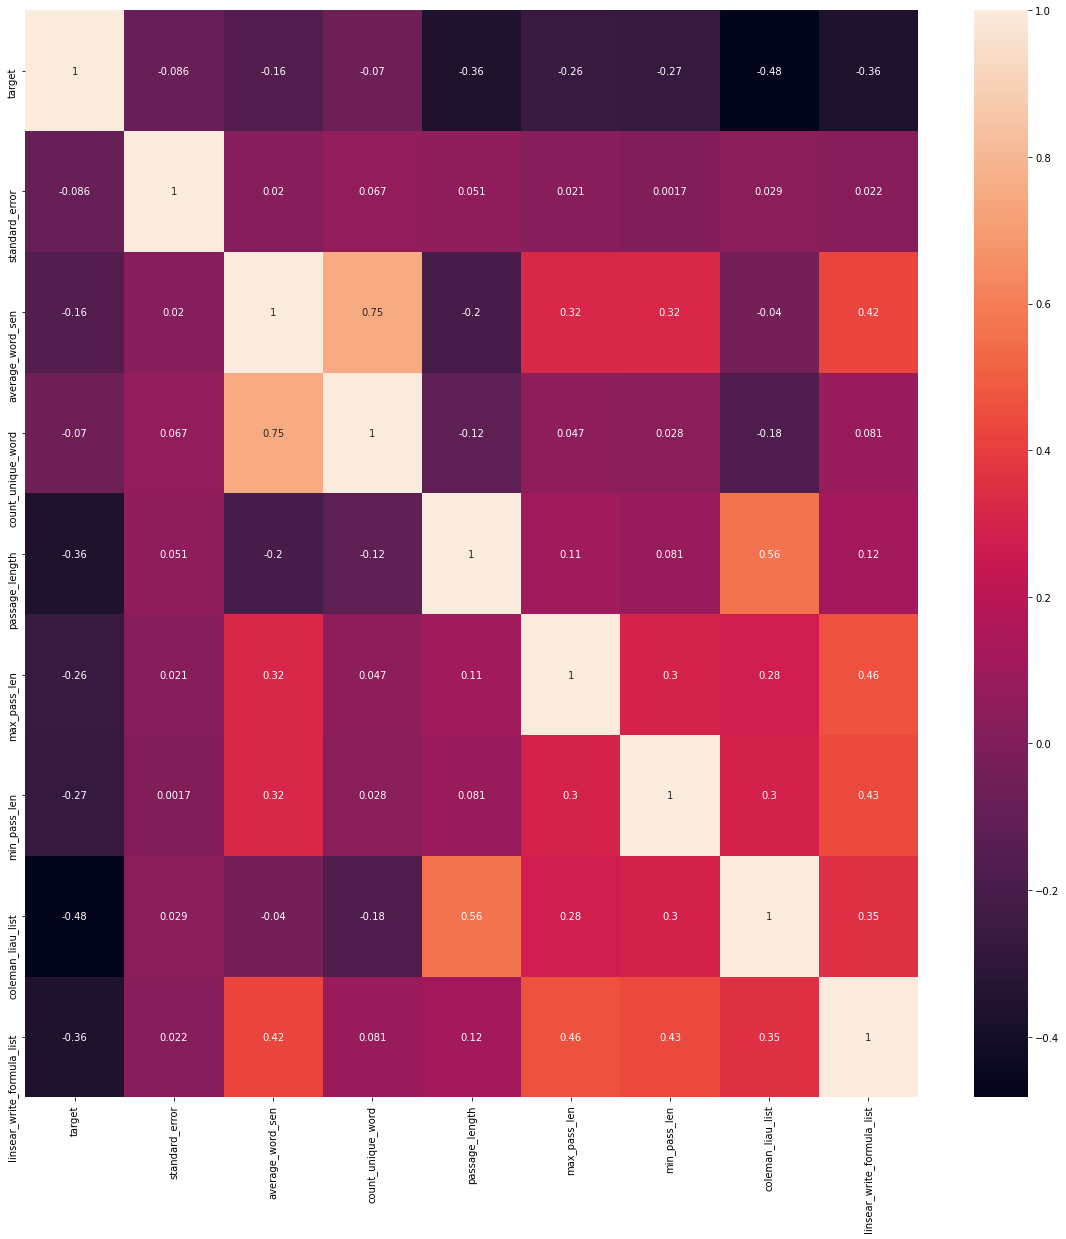

In [38]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(summary_df.corr(), annot = True)

# Model Building

In [39]:
def tokenize_def(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [40]:
kf = KFold(n_splits=10, random_state= 42, shuffle= True)
vect = CountVectorizer(tokenizer=tokenize_def)
tfidf = TfidfTransformer()
clf = RandomForestRegressor()
lgb = LGBMRegressor(max_depth = 2, num_leaves = 50, learning_rate = 0.05)
xgb = XGBRegressor()
svd = TruncatedSVD(n_components=10, n_iter=10, random_state=42)
lasso = Lasso()
ridge = Ridge()

In [41]:
summary_df_vect = vect.fit_transform(summary_df['excerpt'])

In [42]:
summary_df_tfidf = tfidf.fit_transform(summary_df_vect)

In [43]:
summary_df_svd = svd.fit_transform(summary_df_tfidf)

In [44]:
summary_df_svd = pd.DataFrame(summary_df_svd)

In [45]:
sample = pd.merge(summary_df, summary_df_svd, left_index=True, right_index=True)
sample

,id,excerpt,target,standard_error,average_word_sen,count_unique_word,passage_length,max_pass_len,min_pass_len,coleman_liau_list,...,0,1,2,3,4,5,6,7,8,9
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,71.545455,110,992,92,108,8.06,...,0.382786,-0.070226,-0.005849,-0.105997,0.095568,-0.054425,0.059924,-0.028584,0.009778,0.087587
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,150.000000,206,937,17,92,6.78,...,0.279451,0.190501,0.257381,0.168774,0.053410,0.008033,-0.083013,0.099538,-0.074491,0.025380
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,199.636364,288,908,53,37,7.20,...,0.273621,0.119080,0.060120,0.050572,0.018900,-0.023279,-0.017135,0.011043,-0.053624,0.054195
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,581.800000,371,909,60,205,8.54,...,0.318070,0.049144,-0.038582,-0.104894,0.034324,-0.069941,-0.000931,-0.050152,-0.029048,-0.014829
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,690.800000,397,723,171,168,4.83,...,0.227382,0.011863,-0.002065,-0.029747,0.008820,-0.034770,0.085264,-0.108286,-0.058926,0.088319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.646900,218198.900000,29971,901,70,49,10.88,...,0.178111,-0.034785,0.017742,0.058025,-0.007398,-0.065529,0.032552,0.042687,-0.043456,0.021038
2830,2c26db523,So what is a solid? Solids are usually hard be...,0.189476,0.535648,167899.769231,29973,890,54,67,6.59,...,0.243949,-0.092056,0.035698,0.098398,-0.083421,-0.077053,-0.049807,-0.041267,-0.061544,0.014794
2831,cd19e2350,The second state of matter we will discuss is ...,0.255209,0.483866,136464.500000,29975,949,23,45,3.98,...,0.308130,-0.159690,0.036250,0.095158,-0.059636,-0.040559,-0.126866,-0.035962,-0.084961,0.035316
2832,15e2e9e7a,Solids are shapes that you can actually touch....,-0.215279,0.514128,182009.500000,29985,864,90,73,8.34,...,0.293387,-0.172885,0.037996,0.077498,-0.072176,-0.082686,-0.052898,-0.004124,0.013394,-0.041623


In [46]:
X = sample.drop(columns=['id', 'excerpt', 'target'], axis=1)
y = sample['target']

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
params = {'max_depth':[2],'num_leaves':[50],'learning_rate':[0.05]}
model = GridSearchCV(lgb, params)

In [49]:
model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMRegressor(learning_rate=0.05, max_depth=2,
                                     num_leaves=50),
             param_grid={'learning_rate': [0.05], 'max_depth': [2],
                         'num_leaves': [50]})

In [50]:
model.score(X_train, y_train)

0.5826563367567446

In [51]:
model.score(X_test, y_test)

0.5411361265752166

In [52]:
pred = model.predict(X_test)

In [53]:
mean_squared_error(y_test, pred, squared=False)

0.7004420293025162

In [54]:
test_df = test_df.drop(columns=['url_legal','license'],axis=1)

summary_df = test_df

no_sentence = []
total_word = 0
average_word = 0
no_words = []
average_word_sen = []
count_letter = 0
total_letter = []
all_word = []
count_unique_word = []
count = 0
unique_words = []
count_non_stop = []
passage_length = []
max_pass_len = []
min_pass_len = []
sent_passage = []

for passage in summary_df['excerpt']:
    count_sen = len(re.findall(r'\.', passage))
    no_sentence.append(count_sen)
    for sen in passage:
        count_word = len(re.findall(r'\w+', sen))
        total_word += count_word
    average_word = total_word/count_sen
    no_words.append(total_word)
    average_word_sen.append(average_word)
summary_df['no_sen'] = no_sentence
summary_df['no_word'] = no_words
summary_df['average_word_sen'] = average_word_sen


for passage in summary_df['excerpt']:
    for word in re.findall(r'\w+', passage):
        all_word.append(word)
        count_letter += len(word)
    all_word = list(set(all_word))
    count_unique_word.append(len(all_word))
    total_letter.append(count_letter)
summary_df['letter_count'] = count_letter
summary_df['count_unique_word'] = count_unique_word

stop_words = list(set(stopwords.words('english')))
for passage in summary_df['excerpt']:
    words = word_tokenize(passage)
    for w in words:
        if w not in stop_words and w not in unique_words:
            count += 1
            unique_words.append(w)
    count_non_stop.append(count)
summary_df['count_non_stop'] = count_non_stop


for passage in summary_df['excerpt']:
    passage_length.append(len(passage))
    sent_length = sent_tokenize(passage)
    sent_passage.append(sent_length)
    max_pass_len.append(len(max(sent_length)))
    min_pass_len.append(len(min(sent_length)))
summary_df['passage_length'] = passage_length
summary_df['max_pass_len'] = max_pass_len
summary_df['min_pass_len'] = min_pass_len

coleman_liau_list = []
for text in summary_df['excerpt']:
    coleman_liau = textstat.coleman_liau_index(text)
    coleman_liau_list.append(coleman_liau)
    
linsear_write_formula_list = []
for text in summary_df['excerpt']:
    linsear_write_formula = textstat.linsear_write_formula(text)
    linsear_write_formula_list.append(linsear_write_formula)
    
summary_df['coleman_liau_list'] = coleman_liau_list
summary_df['linsear_write_formula_list'] = linsear_write_formula_list

summary_df_vect = vect.fit_transform(summary_df['excerpt'])
summary_df_tfidf = tfidf.fit_transform(summary_df_vect)
summary_df_svd = svd.fit_transform(summary_df_tfidf)
summary_df_svd = pd.DataFrame(summary_df_svd)

test_df = pd.merge(summary_df, summary_df_svd, left_index=True, right_index=True)

df_test = test_df.drop(columns=['id', 'excerpt'], axis=1)

In [55]:
pred = model.predict(df_test)

In [56]:
predictions = pd.DataFrame(pred, columns=['target'])
predictions

,target
0,-1.597374
1,-0.522023
2,-0.762773
3,-1.281702
4,-1.321570
5,-1.549669
6,-0.522023


In [57]:
submission = pd.DataFrame(test_df['id'], columns=['id'])
submission

,id
0,c0f722661
1,f0953f0a5
2,0df072751
3,04caf4e0c
4,0e63f8bea
5,12537fe78
6,965e592c0


In [58]:
submission = pd.merge(submission,predictions, right_index=True, left_index=True)

In [59]:
submission

,id,target
0,c0f722661,-1.597374
1,f0953f0a5,-0.522023
2,0df072751,-0.762773
3,04caf4e0c,-1.281702
4,0e63f8bea,-1.321570
5,12537fe78,-1.549669
6,965e592c0,-0.522023


In [60]:
submission.to_csv("submission.csv",index=False)